# Doc2Vec/STW Visualization

Here, I want to prototype the idea of visualizing the STW tags of documents by their Doc2Vec/t-SNE representations.

It is assumed that every document owns a 'stw' field.

In [1]:
from IPython.lib import kernel

kernel.get_connection_file()

'/run/user/1000/jupyter/kernel-71ca80e8-1d24-4d88-93ca-2f7eeddf4777.json'

In [2]:
import logging

logging.getLogger().setLevel(logging.ERROR)
sourceDir = 'data/json_having_stw'
cacheDir = 'cache'
dimensionality = 100
modelCacheFile = 'havingSTW' + str(dimensionality)  + 'D.model'

An iterator, to go over the corpus

In [3]:
import json
import os
from os.path import isfile, join
from scandir import scandir


class loadItems(object):
    def __init__(self, wd = 'samples'):
        self.wd = wd

    def __iter__(self):
        for doc in scandir(self.wd):
            if doc.is_file() and doc.name.endswith('.json'):
                with open(os.path.join(self.wd, doc.name), 'r') as f:
                    yield json.load(f) 

## A datastructure containing all document's plaintext, their stw tags and a blank field for the corresponding docvecs

In [4]:
from collections import OrderedDict
from tqdm import tqdm

docGen = iter(loadItems(sourceDir))
documents = OrderedDict()

for d in tqdm(docGen):
    try:
        if d['lang'] == 'en':
            documents[d['filename']] = {
                            'stw': tuple(d['stw']),
                            'plaintext': d['plaintext'],
                            'docvecs': None,
                            'docvecs2d': None
                           }
    except KeyError:
        logging.info('KeyError')

## Compute the Doc Vecs

In [5]:
import multiprocessing
import gensim
from utilities.LabeledDocuments import LabeledDocument, loadItems

if os.path.isfile(os.path.join(cacheDir, modelCacheFile)):
    model = gensim.models.Doc2Vec.load(os.path.join(cacheDir, 
                                                    modelCacheFile))
else:
    workers = int(multiprocessing.cpu_count()/1.)
    it = LabeledDocument(normalizeText=False, workers=workers,
                         wd=sourceDir)
    model = gensim.models.Doc2Vec(size=dimensionality, window=10, 
                                  min_count=3, workers=workers, 
                                  alpha=0.025, min_alpha=0.025)
    logging.info('Building vocabulary...')
    model.build_vocab(it)

    for i, epoch in enumerate(range(5)):
        logging.info('beginning interation #' + str(i) + '\n')
        model.train(it)
        model.alpha -= 0.002 # decrease the learning rate
        model.min_alpha = model.alpha # fix the learning rate, no decay

    logging.info('Persisting model')
    model.save(os.path.join('cache', modelCacheFile))
    logging.info('done')

INFO:gensim.utils:loading Doc2Vec object from cache/havingSTW100D.model
INFO:gensim.utils:loading docvecs recursively from cache/havingSTW100D.model.docvecs.* with mmap=None
INFO:gensim.utils:loading syn0 from cache/havingSTW100D.model.syn0.npy with mmap=None
INFO:gensim.utils:loading syn1 from cache/havingSTW100D.model.syn1.npy with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:setting ignored attribute syn0norm to None


## append DocVecs to the documents dict 

In [6]:
for d in documents.keys():
    documents[d]['docvecs'] = model.docvecs[d]

## t-SNE reduction

In [7]:
from sklearn.manifold import TSNE

def tsne(docs, metric='euclidean'):
    # calulate the t-SNE representation
    tsne = TSNE(n_components=2, random_state=0, metric=metric)
    return tsne.fit_transform(docs)

doc2VecGen = (d['docvecs'] for d in documents.values())
docVecs2D = tsne(list(doc2VecGen))

for doc, d2v2D in zip(documents.keys(), docVecs2D):
    documents[doc]['docvecs2d'] = d2v2D

## plot a specific STW topic

In [ ]:
# stw dict
stwDict = {}
for k, tags in documents.items():
    #import pdb; pdb.set_trace()
    for tag in tags['stw']:
        try:
            stwDict[tag].append(k)
        except KeyError:
            stwDict[tag] = [k]

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def plotDocsWithSTWTag(stwTag, ax, color='mediumorchid', alpha=.5,
                       size=200):
    # plot those having a specific stw tag
    handles = []
    docs = []
    for doc in stwDict[stwTag]:
        docs.append(list(documents[doc]['docvecs2d']))
    docs = np.array(docs)
    return ax.scatter(docs[:, 0], docs[:, 1], s=size, c=color, \
                       alpha=alpha, cmap=plt.cm.Spectral)
    
'''    for doc in stwDict[stwTag]:
        handles.append(plt.scatter(documents[doc]['docvecs2d'][0], \
                                   documents[doc]['docvecs2d'][1], \
                                   s=size, c=color, alpha=alpha, \
                                   cmap=plt.cm.Spectral))
    return handles'''

def plotAllDocs(ax):
    handles = []
    # all the others
    for doc in documents.values():
        handles.append(ax.scatter(doc['docvecs2d'][0], \
                                  doc['docvecs2d'][1], \
                                  s=50, c='black', alpha=.05, \
                                  cmap=plt.cm.Spectral))
    return handles


#stwTag = '12070-5' # 115, nice!
#stwTag = '10410-3' # 54, nice
stwTag = '10300-3' # 221, evenly distributed
#stwTag = '11379-1' # 42, one nice cluster
#stwTag = '10338-6' # 390, widely distributed, with one cluster
#stwTag = '20399-1' # 13, widely distributed
#stwTag = '11702-6' # 91, some clustering
#stwTag = '10300-3' # 221, few clusters, broadly distributed
#stwTag = '18012-3' # 3094, massive, everywhere
#stwTag = '19041-5' # 150, moderate clustering
#stwTag = '19637-0' # 10, one small cluster
#stwTag = '11559-6' # 37, one very wide cluster
#stwTag = '29633-2' # 26, two clusters
#stwTag = '10057-0' # 166, widely distributed
#stwTag = '27601-4' # one broad cluster
#stwTag = '29611-5' # 48, one dense cluster, the rest ist distributed
#stwTag = '15477-2' # 93, two clusters, some distributed entries
#stwTag = '11422-5' # 13, one nice cluster
#stwTag = '15861-1' # 129, one very strong cluster!!!
#stwTag = '19438-6' # 99, some clustering
#stwTag = '15837-5' # 58, one longish cluster
#stwTag = '10037-6' # 30, no cluster
#stwTag = '12031-1' # 30, no cluster
#stwTag = '18538-0' # 66, one broad cluster
#stwTag = '15945-2' # 241, interesing, widely distributed,
                    # but only on one side
#stwTag = '11327-6' # 411, one huge cluster
#stwTag = '12174-0' # 20, no cluster
#stwTag = '19360-3' # 70 nice cluster
#stwTag = '10698-4' # 45 nice cluster
for stwTag in tqdm(stwDict.keys()):
    myHandles = []
    fig = plt.figure(figsize=(10, 10), dpi=150)
    ax = fig.add_subplot(111)
    try:
        plotDocsWithSTWTag(stwTag, ax)
    except KeyError:
        pass
    plotAllDocs(ax)
    ax.set_title(stwTag)
    fig.savefig(os.path.join('data', 'images', stwTag + '.png'))
    plt.close(fig)

  0%|          | 4/3725 [01:35<24:44:56, 23.94s/it]

In [ ]:
fig

## Visualize one document and all the other documents that share at least one tag with that document

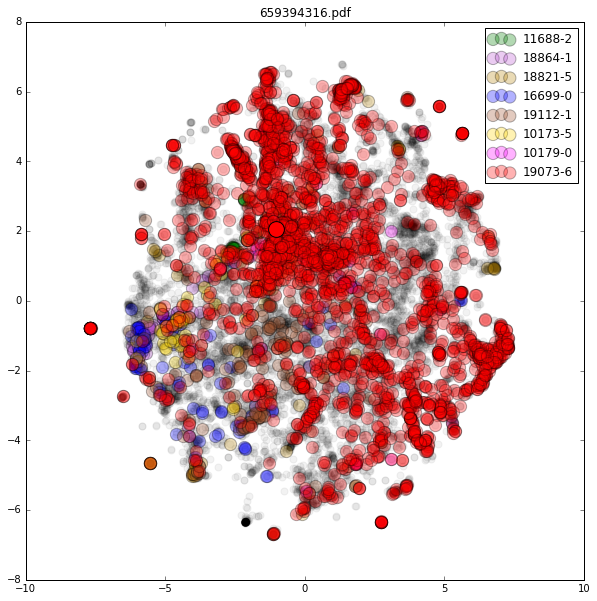

In [205]:
#candidate = '623311542.pdf' # too much
#candidate = '757180892.pdf' # okay-ish
#candidate = '747427585.pdf' # interesting, worth exploring more closely
#candidate = '655731857.pdf' # too much
#candidate = '738371890.pdf' # only one tag?
candidate = '659394316.pdf' # eigth tags!
#candidate = '728679345.pdf' # confusing
#candidate = '685007626.pdf' # confusing
#candidate = '738469769.pdf' # nice, interesting
#candidate = '735097992.pdf' # interesing

niceColors = ['green', 'mediumorchid', 'darkgoldenrod', 'blue', \
              'sienna', 'gold', 'fuchsia', 'red', 'white']

# plot all
plt.figure(figsize=(10, 10), dpi=150)
plotAllDocs(plt)

# plot document shring at least one tag
myHandles = []
for stwTag, color in zip(documents[candidate]['stw'], niceColors):
    myHandles.append(plotDocsWithSTWTag(stwTag, plt, color=color,
                                       size=150, alpha=.3))

# plot the doc itself    
plt.scatter(documents[candidate]['docvecs2d'][0], \
            documents[candidate]['docvecs2d'][1], s=250, c='red', \
            alpha=1, cmap=plt.cm.Spectral)
    
plt.title(candidate)
plt.legend(myHandles, documents[candidate]['stw'])
plt.show()
#pylab.savefig(os.path.join('data', 'images', candidate + '.png'))

## tinkering with the stw tags

In [11]:
from itertools import chain

docGen = iter(loadItems(sourceDir))
stwTopics = [d['stw'] for d in docGen]

stwTopicsList = list(chain(*stwTopics))
stwTopicsSet = set(chain(stwTopicsList))

occurances = {}
for i, t in enumerate(stwTopicsSet):
    occurances[t] = stwTopicsList.count(t)